# Assignment 3
Nathan Jester

## Part 1: Data Loading, Exploration, and Cleaning

### 1 Data Prepairation

### 1.1 Data Loading

Our goals is to build a mdoel for both prediction and explaination so we'll start with 2 dataframes, predict_df and explain_df.

In [522]:
from pathlib import Path

import pandas as pd


data_path = Path("heart_disease_uci-1.csv")
predict_df = pd.read_csv(data_path, index_col='id')
explain_df = pd.read_csv(data_path, index_col='id')
explain_df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### 1.2 Data Exploration and Cleaning

#### 1.2.1 Handle Missing Values

For now the two dataframes are the same so lets look at missingness in explain_df.

In [523]:
missing_df = pd.DataFrame()
num_rows = explain_df.shape[0]
missing_count = explain_df.isna().sum()
missing_df["Missing Count"] = missing_count
missing_df["Missing %"] = round((missing_count / num_rows) * 100, 2)
missing_df.sort_values('Missing Count', inplace=True, ascending=False)
missing_df


,Missing Count,Missing %
ca,611,66.41
thal,486,52.83
slope,309,33.59
fbs,90,9.78
oldpeak,62,6.74
trestbps,59,6.41
thalch,55,5.98
exang,55,5.98
chol,30,3.26
restecg,2,0.22


Explainatory modeling requires understanding of missingness of values and handling of them apropriately.  Handling missing values apropriatly commonly requires domain knowledge and in this case I have none, so I will drop the colums that are missing lots of data.  

Predictive modeling is less picky about missingness and is able to pick up effects between variables that weren't oribinally being looked for.  As a result, any data cleaning that improves the prediction is valid.  

For simplicity, I'll drop ca, thal, and slope, then handle missing values ona per dataframe basis.

In [524]:
cols_to_drop = ["ca", "thal", "slope"]
explain_df.drop(columns=cols_to_drop, inplace=True)
predict_df.drop(columns=cols_to_drop, inplace=True)

Next lets handle the missing values.

For predict_df we'll impute valeus for missing data.  For now, imputed values will simple be the mean, for simplicity.

In [525]:
# get fill values
numeric_cols = predict_df.select_dtypes([int, float]).columns
numeric_col_means = predict_df[numeric_cols].mean()
print("Numeric Column Means")
print(numeric_col_means)

# apply fill values
fill_val_map = {col: mean for col, mean in numeric_col_means.items()}
predict_df.fillna(fill_val_map, inplace=True)

# show results
print("\nNumeric Column Missing Counts")
print(predict_df[numeric_cols].isna().sum())

Numeric Column Means
age          53.510870
trestbps    132.132404
chol        199.130337
thalch      137.545665
oldpeak       0.878788
num           0.995652
dtype: float64

Numeric Column Missing Counts
age         0
trestbps    0
chol        0
thalch      0
oldpeak     0
num         0
dtype: int64


For explain_df, we'll drop rows with missing data.

In [526]:
print("Row count before dropping missing values", explain_df.shape[0])
explain_df.dropna(inplace=True)
print("Row count after dropping missing values", explain_df.shape[0])

Row count before dropping missing values 920
Row count after dropping missing values 740


#### 1.2.2 Explore and Clean Catagorical Variables

Next, lets identify catagorical variables and split them into dummy variables.

In [527]:
print(predict_df.dtypes)
predict_df.head()

age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
num           int64
dtype: object


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
id,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


In [528]:
catagorical_columns=["sex", "dataset", "cp", "fbs", "restecg", "exang"]

Before cleaning, lets look at the distribtuion of catagorical variables.

Following are the explainatory distributions.

{'sex': 2, 'dataset': 4, 'cp': 4, 'fbs': 2, 'restecg': 3, 'exang': 2}


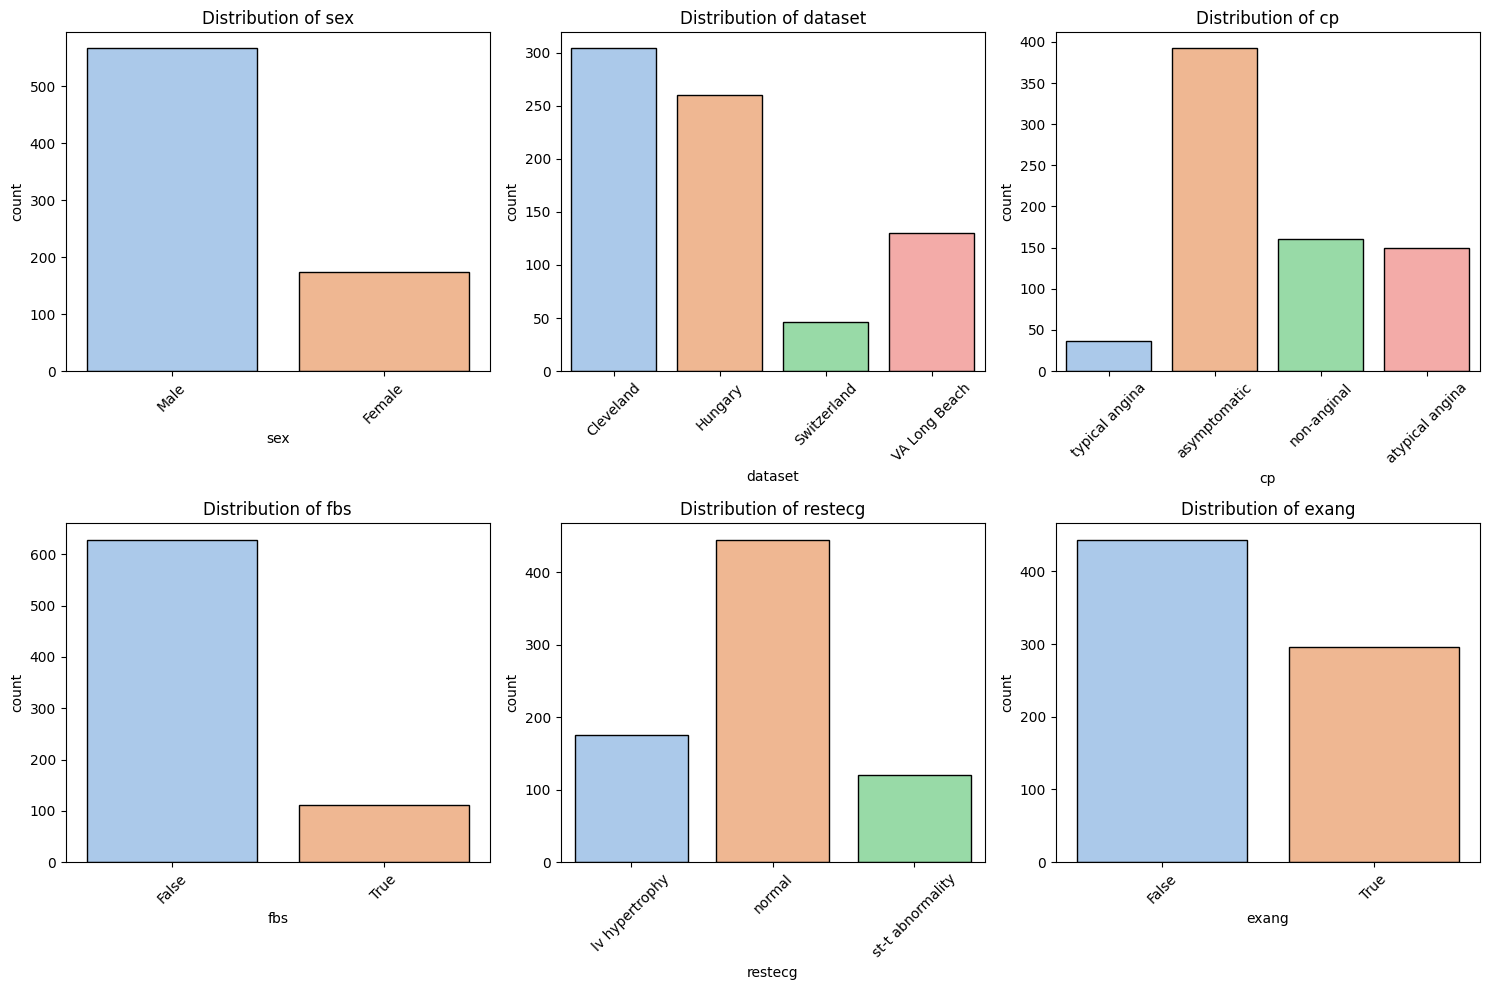

In [529]:
from matplotlib import pyplot as plt
import seaborn as sns


unique_counts = {col: explain_df[col].nunique() for col in catagorical_columns}
print(unique_counts)

plt.figure(figsize=(15, 10))
for i, col in enumerate(catagorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout for better visualization
    sns.countplot(data=explain_df, x=col, hue=col, palette="pastel", edgecolor="black", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Following are the predict_df distributions.

{'sex': 2, 'dataset': 4, 'cp': 4, 'fbs': 2, 'restecg': 3, 'exang': 2}


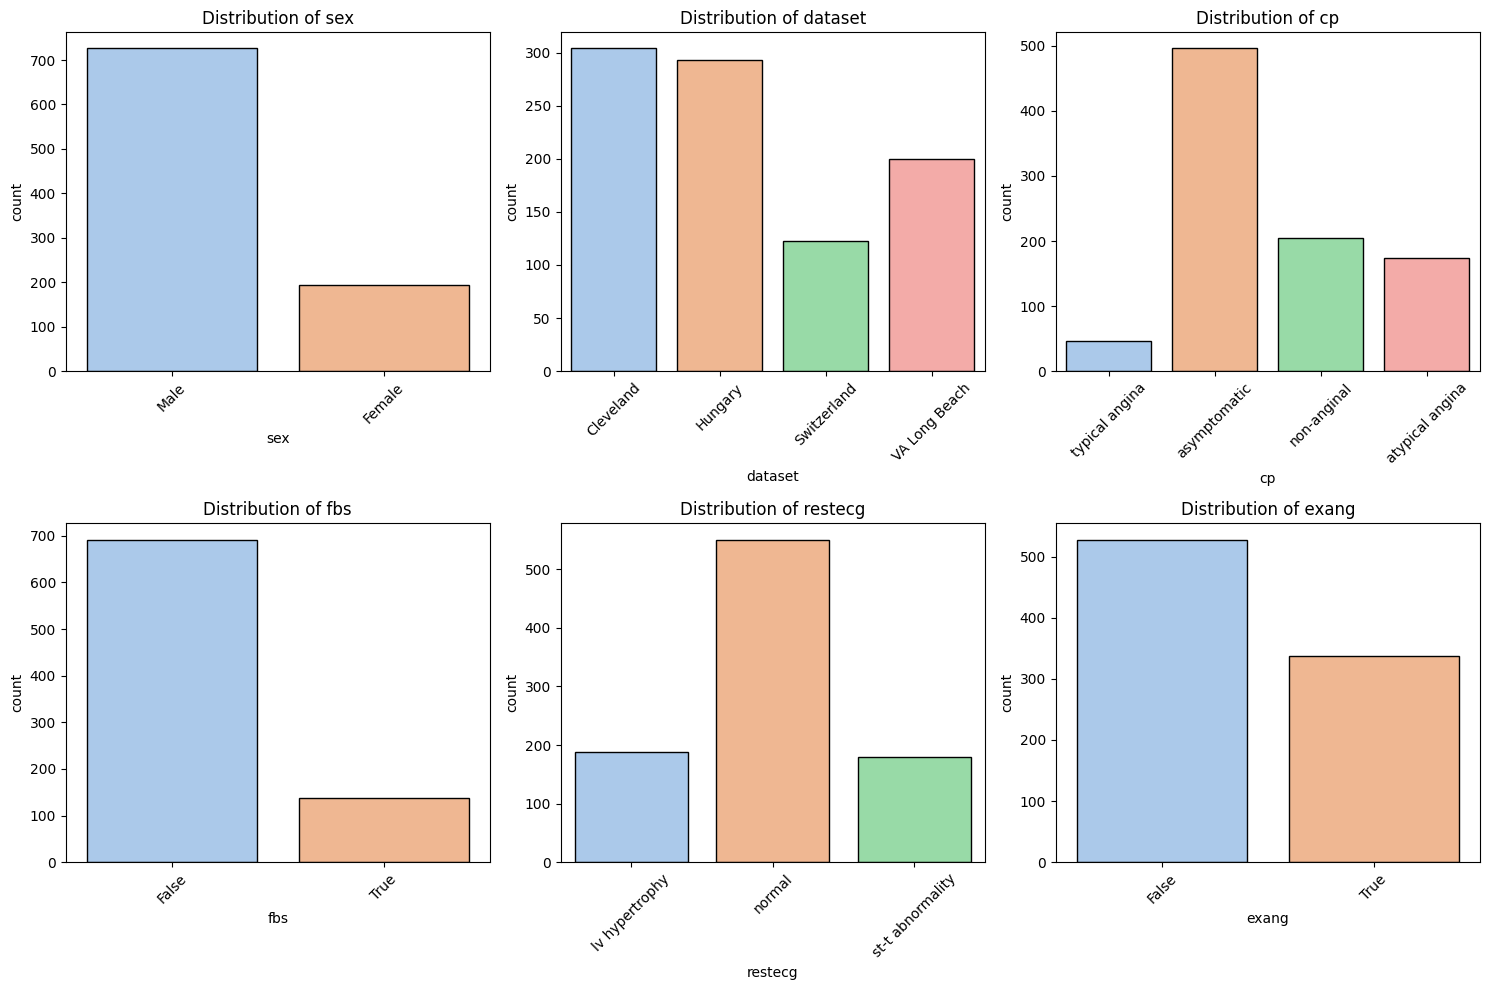

In [530]:
from matplotlib import pyplot as plt
import seaborn as sns


unique_counts = {col: explain_df[col].nunique() for col in catagorical_columns}
print(unique_counts)

plt.figure(figsize=(15, 10))
for i, col in enumerate(catagorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout for better visualization
    sns.countplot(data=predict_df, x=col, hue=col, palette="pastel", edgecolor="black", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Both look very similar so it appears that dropping missing values didn't have a huge impact on the data.

For explain_df, we'll leave all the catagorical variables in.  This introduces the chance of multicolinearitiy, but also allows us to extract statistics for each varible, such as their p value.

In [531]:
explain_df = pd.get_dummies(explain_df, columns=catagorical_columns, dtype=int)
explain_df.columns = [c.replace(' ', '_').lower() for c in explain_df.columns]
print(explain_df.dtypes)
explain_df.head()

age                           int64
trestbps                    float64
chol                        float64
thalch                      float64
oldpeak                     float64
num                           int64
sex_female                    int64
sex_male                      int64
dataset_cleveland             int64
dataset_hungary               int64
dataset_switzerland           int64
dataset_va_long_beach         int64
cp_asymptomatic               int64
cp_atypical_angina            int64
cp_non-anginal                int64
cp_typical_angina             int64
fbs_false                     int64
fbs_true                      int64
restecg_lv_hypertrophy        int64
restecg_normal                int64
restecg_st-t_abnormality      int64
exang_false                   int64
exang_true                    int64
dtype: object


,age,trestbps,chol,thalch,oldpeak,num,sex_female,sex_male,dataset_cleveland,dataset_hungary,...,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_false,fbs_true,restecg_lv_hypertrophy,restecg_normal,restecg_st-t_abnormality,exang_false,exang_true
id,,,,,,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,0,0,1,1,0,...,0,0,1,0,1,1,0,0,1,0
2,67,160.0,286.0,108.0,1.5,2,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
3,67,120.0,229.0,129.0,2.6,1,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1
4,37,130.0,250.0,187.0,3.5,0,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
5,41,130.0,204.0,172.0,1.4,0,1,0,1,0,...,1,0,0,1,0,1,0,0,1,0


For predict_df, we're not as concerned about explainability and prefer to drop variables to avoid multicolinearity and provide a better prediction.

In [532]:
predict_df = pd.get_dummies(predict_df, columns=catagorical_columns, dtype=int, drop_first=True)
predict_df.columns = [c.replace(' ', '_').lower() for c in predict_df.columns]
print(predict_df.dtypes)
predict_df.head()

age                           int64
trestbps                    float64
chol                        float64
thalch                      float64
oldpeak                     float64
num                           int64
sex_male                      int64
dataset_hungary               int64
dataset_switzerland           int64
dataset_va_long_beach         int64
cp_atypical_angina            int64
cp_non-anginal                int64
cp_typical_angina             int64
fbs_true                      int64
restecg_normal                int64
restecg_st-t_abnormality      int64
exang_true                    int64
dtype: object


,age,trestbps,chol,thalch,oldpeak,num,sex_male,dataset_hungary,dataset_switzerland,dataset_va_long_beach,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_true,restecg_normal,restecg_st-t_abnormality,exang_true
id,,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,0,1,0,0,0,0,0,1,1,0,0,0
2,67,160.0,286.0,108.0,1.5,2,1,0,0,0,0,0,0,0,0,0,1
3,67,120.0,229.0,129.0,2.6,1,1,0,0,0,0,0,0,0,0,0,1
4,37,130.0,250.0,187.0,3.5,0,1,0,0,0,0,1,0,0,1,0,0
5,41,130.0,204.0,172.0,1.4,0,0,0,0,0,1,0,0,0,0,0,0


#### 1.2.3 Explore Numeric Variables

Lets view the explain_df numeric variable distributions.

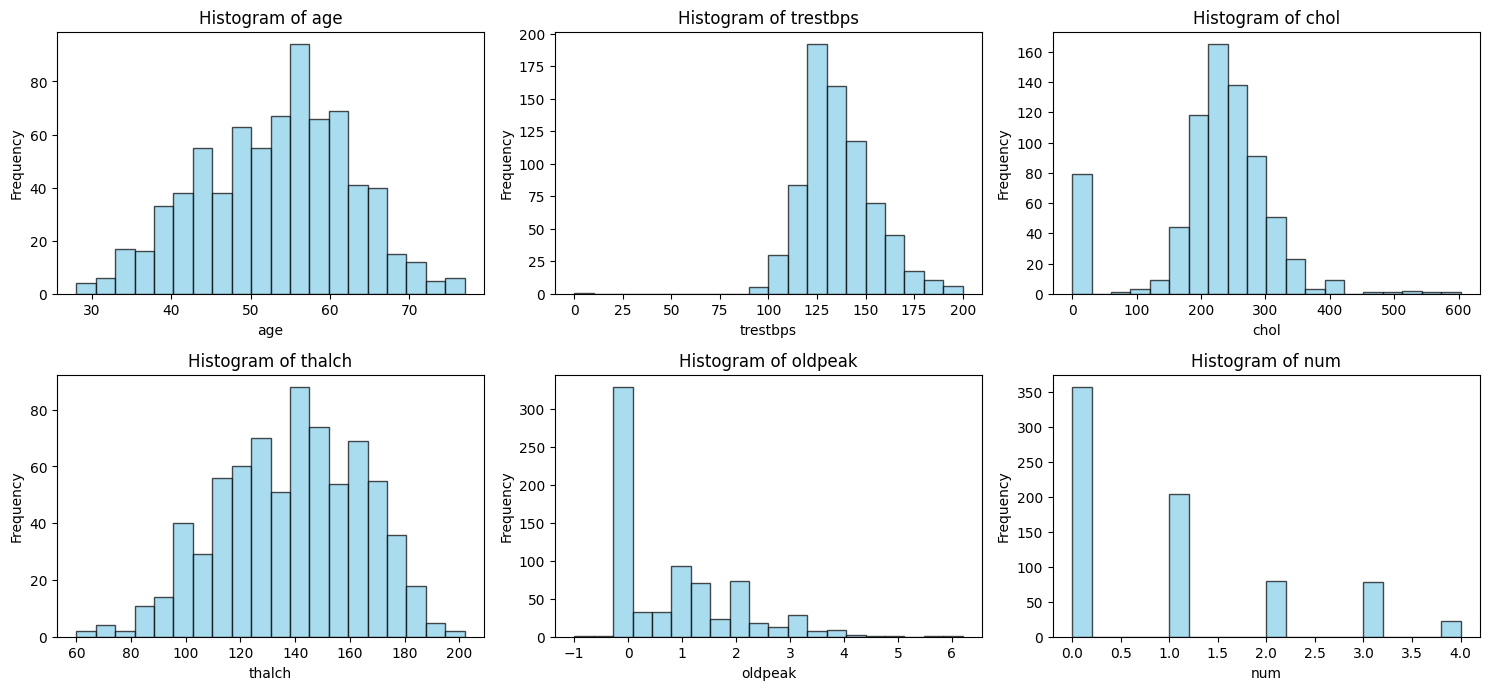

In [533]:
# Generate histograms for numerical variables
from matplotlib import pyplot as plt


plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust layout for better visualization
    plt.hist(explain_df[col].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Next, lets view the distribution of the prediction variables.

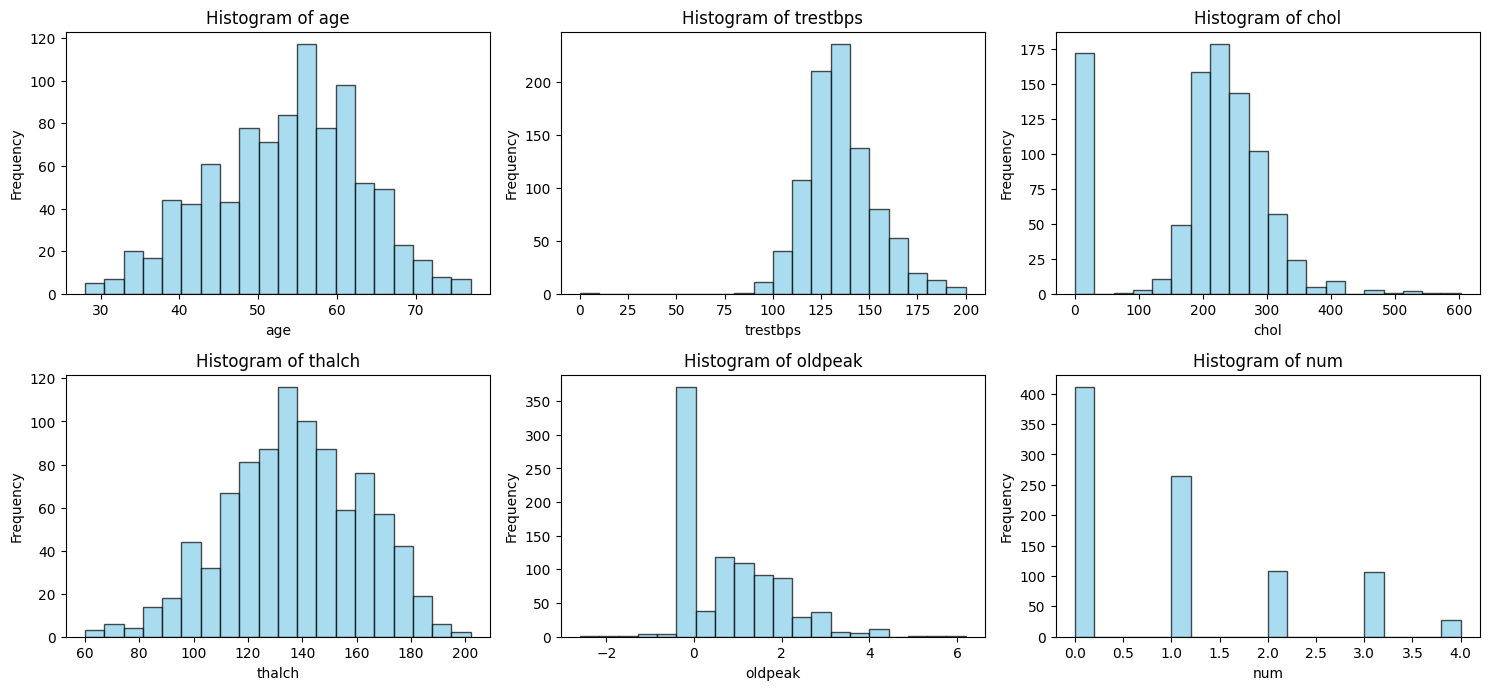

In [534]:
# Generate histograms for numerical variables
from matplotlib import pyplot as plt


plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust layout for better visualization
    plt.hist(predict_df[col].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Final Data Prep Considerations and Assumptions:
- NUM's Data Type: num appears to be an ordinal catagorical variable.  Since it will be the target variable, I'll leave it alone.  Becaues it's ordinal, a model like regression can simply estimate a float on the scale of 0 through 4.  In practice, the prediction would be rounded to the nerest integer to select a prediction.
- Data Collection: Ideally, for explainatory modeling, the data would have come from controlled experiment features, esigned to test a hypothesis.  In this case, all data will be used and p scores will be used to assess the meaningfullness of features.  Due to a lack of information on the collection of the dataset, and to support this comparison of Explainatory vs Predictive models, I will assume that this is primary data, and therefore num was collected experimentally to support a model that explains it's connection to the features.
- Varible Meaning: I assume that with more research, I could understand what each variable represents.  For an experimental model, I could use domain knowledge to make feature engineering decidions.  For this experiment, to control the assignments scope, I will not attempt to assess the meaning of variables and make decisions based solely on variables attributes and behaviours.

Ideall

Our data appears to be clean and ready for modeling.

## 2 Data Modeling

### 2.1 Explainitory Modeling

For this excercise, I will build an explaination that, with the assumptions listed at the end of the previous section, will establish a causal relationship between Y (num), and X (the other features).

In order to do this, I will be using Linear Regression which is explainable thanks to returning coefficents, but also works well for prediction in many cases.  I will also use metrics statistical tools such as the p score to assess the statistical significance of each feature.

For this section, train test splits will not be created as they sacrifice modeling the current data set for predictive evaluation (See "To Explain or Predict?, G Shmueli 2010, Section 2.2.2)

#### 2.1.1 Explainable Linear Regression

Define the features, X, and the target variable, y.

In [535]:
y_column_name = 'num'
X_columns_names = [c for c in explain_df.columns if c != y_column_name]
y = explain_df[y_column_name]
X = explain_df[X_columns_names]
print("y:", ', '.join(map(str, y[:10].tolist())), "..., len:", len(y))
print("X:")
print("\tX shape:", X.shape)
print("\tX columns:", X.columns.tolist())
X.head()

y: 0, 2, 1, 0, 0, 0, 3, 0, 2, 1 ..., len: 740
X:
	X shape: (740, 22)
	X columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_female', 'sex_male', 'dataset_cleveland', 'dataset_hungary', 'dataset_switzerland', 'dataset_va_long_beach', 'cp_asymptomatic', 'cp_atypical_angina', 'cp_non-anginal', 'cp_typical_angina', 'fbs_false', 'fbs_true', 'restecg_lv_hypertrophy', 'restecg_normal', 'restecg_st-t_abnormality', 'exang_false', 'exang_true']


,age,trestbps,chol,thalch,oldpeak,sex_female,sex_male,dataset_cleveland,dataset_hungary,dataset_switzerland,...,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_false,fbs_true,restecg_lv_hypertrophy,restecg_normal,restecg_st-t_abnormality,exang_false,exang_true
id,,,,,,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,0,1,1,0,0,...,0,0,1,0,1,1,0,0,1,0
2,67,160.0,286.0,108.0,1.5,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,1
3,67,120.0,229.0,129.0,2.6,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,1
4,37,130.0,250.0,187.0,3.5,0,1,1,0,0,...,0,1,0,1,0,0,1,0,1,0
5,41,130.0,204.0,172.0,1.4,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0


I'll use statsmodel to get p values to determine which variables are stastically significant.

In [536]:
import statsmodels.api as sm


X_constrain = sm.add_constant(X)
linear_regression_model = sm.OLS(y, X_constrain)
results = linear_regression_model.fit()
original_summary = results.summary()
print(original_summary)

                            OLS Regression Results                            
Dep. Variable:                    num   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     41.54
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           4.58e-91
Time:                        20:40:33   Log-Likelihood:                -898.02
No. Observations:                 740   AIC:                             1830.
Df Residuals:                     723   BIC:                             1908.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Next, I will remove the variables with a p score higher than 0.05, meaning that those scores are likley supported by the null hypothesis.

In [537]:
result = pd.DataFrame()
result['P Value'] = results.pvalues.sort_values(ascending=False).round(2)
# lets set the cutoff at a 5% chance supporting the null hypothesis
cutoff = 0.05
result['Significant'] = result['P Value'] < cutoff
significant_columns = result[result['Significant']].index
print("Significant Columns:", ", ".join(significant_columns))
print(result)

Significant Columns: dataset_cleveland, fbs_true, restecg_lv_hypertrophy, thalch, exang_true, sex_male, cp_asymptomatic, dataset_hungary, dataset_switzerland, oldpeak
                          P Value  Significant
exang_false                  0.99        False
cp_atypical_angina           0.93        False
dataset_va_long_beach        0.76        False
restecg_normal               0.75        False
fbs_false                    0.62        False
cp_non-anginal               0.60        False
trestbps                     0.59        False
sex_female                   0.57        False
chol                         0.45        False
restecg_st-t_abnormality     0.41        False
cp_typical_angina            0.37        False
const                        0.08        False
age                          0.06        False
dataset_cleveland            0.03         True
fbs_true                     0.03         True
restecg_lv_hypertrophy       0.02         True
thalch                       0.02 

Finally, we'll build a model with only the significant columns.

In [538]:
X_constrain = sm.add_constant(X[significant_columns])
linear_regression_model = sm.OLS(y, X_constrain)
results = linear_regression_model.fit()
significant_summary = results.summary()
print(significant_summary)

                            OLS Regression Results                            
Dep. Variable:                    num   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     65.68
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           7.94e-95
Time:                        20:40:33   Log-Likelihood:                -901.55
No. Observations:                 740   AIC:                             1825.
Df Residuals:                     729   BIC:                             1876.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

**Analysis**

The larger F score means that the second model explains more of the variation, while maintaining all other statistics.  The second model provides a better explaination of impact of X on y with far less data and should be used to inform the understanding of the relationship between X and y.  Ultimatly, the residuals show that linear regression wasn't a good fit inspite of promising summary results.


#### Predictive Linear Regression

In [539]:
y_column_name = 'num'
X_columns_names = [c for c in predict_df.columns if c != y_column_name]
y = predict_df[y_column_name]
X = predict_df[X_columns_names]
print("y:", ', '.join(map(str, y[:10].tolist())), "..., len:", len(y))
print("X:")
print("\tX shape:", X.shape)
print("\tX columns:", X.columns.tolist())
X.head()

y: 0, 2, 1, 0, 0, 0, 3, 0, 2, 1 ..., len: 920
X:
	X shape: (920, 16)
	X columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_male', 'dataset_hungary', 'dataset_switzerland', 'dataset_va_long_beach', 'cp_atypical_angina', 'cp_non-anginal', 'cp_typical_angina', 'fbs_true', 'restecg_normal', 'restecg_st-t_abnormality', 'exang_true']


,age,trestbps,chol,thalch,oldpeak,sex_male,dataset_hungary,dataset_switzerland,dataset_va_long_beach,cp_atypical_angina,cp_non-anginal,cp_typical_angina,fbs_true,restecg_normal,restecg_st-t_abnormality,exang_true
id,,,,,,,,,,,,,,,,
1,63,145.0,233.0,150.0,2.3,1,0,0,0,0,0,1,1,0,0,0
2,67,160.0,286.0,108.0,1.5,1,0,0,0,0,0,0,0,0,0,1
3,67,120.0,229.0,129.0,2.6,1,0,0,0,0,0,0,0,0,0,1
4,37,130.0,250.0,187.0,3.5,1,0,0,0,0,1,0,0,1,0,0
5,41,130.0,204.0,172.0,1.4,0,0,0,0,1,0,0,0,0,0,0


For prediction, unlike the explainable case, we do not need p values and decisions are only driven by the quality of predictions.  Sklearn will will be used for regression and a train test split will be used to evaluate the prediction.

Linear Regression R^2: 0.4416749773226758


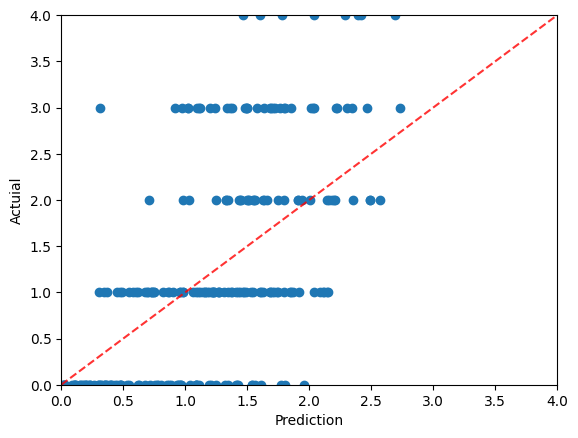

In [540]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
plt.scatter(x=y_pred, y=y_test)
plt.plot([0, 4], [0, 4], 'r--', alpha=0.8)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel('Prediction')
plt.ylabel("Actuial")
r_score = r2_score(y_test, y_pred)
print("Linear Regression R^2:", r_score)

Since this is a predictive model we only care about the quality of predictions.  That's not great, but perhaps varible scale is throwing off the model.  Since the actuial values are generally higher than the linear predictions, there must be a non-linear relationship.  Lets try a non-linear regression model.  It can also be seen that this mdoel only somewhat accuratly predicts actuial values of 1 and 2 but never gets 0, 3, or 4.  Overall this model isn't great.

In [576]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", accuracy)

Decision Tree Accuracy: 0.47101449275362317


The decision tree is accurate 47% of the time.  Which might be better than a random nieve guess, which would be correct 25% of the time.  Since this model appears to be better than a random guess, it has value.  Weather or not it has much value depends on the field in which it is used.

With further exploration and experimentation, a better model could be formed, but for now this shows the general predictive model buliding process.

### 1.3 Conclusion

In conclusion, you can see that the decision to make a explanitory or predictive model affects much as the data prepairation, model building, and analysis process.  An explainatory model exclusivly cares about the significance of variable at predicting the current data set while a predictive model is judged by the quality of it's predictions.  These differences in goals of models affect about every step in the model development process.